## Results visualization tutorial
This notebook is an example of visualizing the spatial data stored as `geopandas` data frame, in both "point" format and "gridded" format.
We also use `cartopy` to plot the basemap.

There are several modules used in this tutorial are not the dependencies of `ml_lsmodel_ascat`. Therefore, they need to be installed first:
- geopandas
- cartopy
- shapely
- matplotlib
- fiona

We assume `ml_lsmodel_ascat` and its dependencies is alreay available in the environment.

In [1]:
!conda install cartopy matplotlib shapely matplotlib geopandas

Then we import all the required dependencies.

In [2]:
import pickle
import numpy as np
import shapely
import geopandas as gpd
import cartopy
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker

Then we load the data for visualization. Pickled test data is loaded here. It is a `Dataframe` with 6 data columns: [mean_sig,mean_slop, mean_curv, mean_sig_cp, mean_slop_cp, mean_curv_cp]. The latter three columns are duplicated from the first three. 
After loading, We convert it into a `GeoDataFrame`.


In [3]:
file_data_gs = '../example/example_data/testdata_plot_mean_sig_slop_curv.pickle'

with open(file_data_gs, 'rb') as f:
    df_plot_gs = pickle.load(f)
gdf = gpd.GeoDataFrame(df_plot_gs,
                       crs=4326,
                       geometry=gpd.points_from_xy(df_plot_gs.lon,
                                                   df_plot_gs.lat))

gdf

,lat,lon,mean_sig,mean_slop,mean_curv,mean_sig_cp,mean_slop_cp,mean_curv_cp,geometry
0,41.125,-4.875,-11.751122,-0.138392,0.000643,-11.751122,-0.138392,0.000643,POINT (-4.87500 41.12500)
1,41.125,-4.625,-11.653749,-0.132772,0.000814,-11.653749,-0.132772,0.000814,POINT (-4.62500 41.12500)
2,41.125,-4.375,-11.592354,-0.128929,0.000981,-11.592354,-0.128929,0.000981,POINT (-4.37500 41.12500)
3,41.125,-4.125,-11.422322,-0.123554,0.000528,-11.422322,-0.123554,0.000528,POINT (-4.12500 41.12500)
4,41.125,-3.875,-11.049291,-0.116087,0.000078,-11.049291,-0.116087,0.000078,POINT (-3.87500 41.12500)
...,...,...,...,...,...,...,...,...,...
2550,49.875,8.875,-7.754148,-0.073296,-0.001900,-7.754148,-0.073296,-0.001900,POINT (8.87500 49.87500)
2551,49.875,9.125,-8.176313,-0.073926,-0.001747,-8.176313,-0.073926,-0.001747,POINT (9.12500 49.87500)
2552,49.875,9.375,-8.521921,-0.079947,-0.001503,-8.521921,-0.079947,-0.001503,POINT (9.37500 49.87500)
2553,49.875,9.625,-8.726479,-0.084362,-0.001257,-8.726479,-0.084362,-0.001257,POINT (9.62500 49.87500)


Then we crop it to with a polygon of France. This can be easily done by the `clip` function.

In [4]:
# Crop with Polygon of France
shp_file = '../example/example_data/shp/france.shp'
poly_france = gpd.read_file(shp_file)
gdf_france = gpd.clip(gdf, poly_france)

Now we want to visulize the cropped results. To do it nicely, we also want to adde some basemap elements from `cartopy`. Here we add the `coastline` and `ocean`.

In [5]:
# Basemap elements
basemap_scale = '50m'
coast = cartopy.feature.NaturalEarthFeature(category='physical',
                                            scale=basemap_scale,
                                            name='coastline',
                                            facecolor='none',
                                            edgecolor='k')
ocean = cartopy.feature.NaturalEarthFeature(category='physical',
                                            scale=basemap_scale,
                                            name='ocean',
                                            facecolor='#DDDDDD')

We would also change the projection to the center of the AoI for better visualization effect.

In [6]:
xmin, ymin, xmax, ymax = gdf_france.total_bounds
plot_crs = cartopy.crs.Orthographic(central_longitude=(xmin + xmax) / 2.,
                                    central_latitude=(ymin + ymax) / 2.,
                                    globe=None)
gdf_france = gdf_france.to_crs(plot_crs.proj4_init)

After the preparation work is done, we visualize the point data.

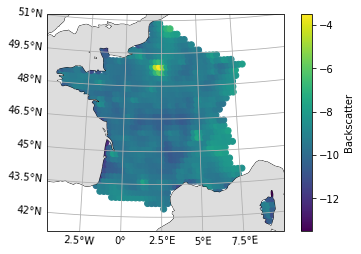

In [7]:
fig1, ax1 = plt.subplots(subplot_kw={'projection': plot_crs})

gdf_france.plot(ax=ax1, column='mean_sig', legend=True, legend_kwds={'label': "Backscatter"})
ax1.add_feature(coast, lw=0.8)
ax1.add_feature(ocean)

# Add grid lines with customized x/y ticks
gl = ax1.gridlines(draw_labels=True)
gl.xlocator = mticker.FixedLocator([-2.5, 0, 2.5, 5, 7.5])
gl.top_labels = False
gl.right_labels = False

Since the point data can block each other, we can grid the point for visualization.
First we will create the grids with `geopandas`. Later the values of the points can be aggregated to the grid cells. 
Since we want to make square gridcells, we will only compute gridsize from one direction.

In [8]:
# Get the grid size
n_grids_x = 50 # number of grids in x direction
grid_size = (xmax - xmin) / n_grids_x

# Making grids
grid_cells = []
for x0 in np.arange(xmin+grid_size/2., xmax + grid_size*1.5, grid_size):
    for y0 in np.arange(ymin-grid_size/2., ymax + grid_size/2., grid_size):
        x1 = x0 - grid_size
        y1 = y0 + grid_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
grids = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=gdf.crs)

We can visulize the grids against the point data.

<GeoAxesSubplot:>

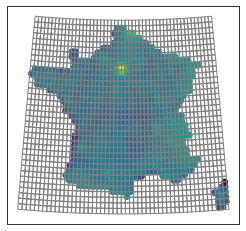

In [9]:
grids = grids.to_crs(plot_crs.proj4_init)
fig0, ax0 = plt.subplots(subplot_kw={'projection': plot_crs})
gdf_france.plot(ax=ax0, column='mean_sig')
grids.plot(ax=ax0, facecolor="none", edgecolor='grey')

The next step, is to aggregate the point data to grids. We can use the `sjoin` function to join the point feature and the grid feature, and use the `dissolve` function to aggregate the point values to the corresponding gridcell. Finally, we can assign the dissolved values to the original grid.

In [10]:
# Gridding the points
merged = gpd.sjoin(gdf_france, grids, how='inner', op='within')
dissolve = merged.dissolve(by="index_right", aggfunc="mean")

# Assign the dissolved values to the original grid 
for col in [
        'mean_sig', 'mean_slop', 'mean_curv', 'mean_sig_cp', 'mean_slop_cp',
        'mean_curv_cp'
]:
    grids.loc[dissolve.index, col] = dissolve[col].values

The gridded data can also be easily visualized with the `plot` function.

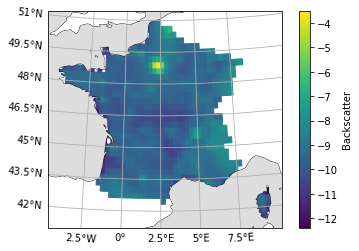

In [11]:
fig1, ax1 = plt.subplots(subplot_kw={'projection': plot_crs})
grids.plot(ax=ax1, column='mean_sig', edgecolor="face", legend=True, legend_kwds={'label': "Backscatter"})
ax1.add_feature(coast, lw=0.8)
ax1.add_feature(ocean)
# Add grid lines with customized x/y ticks
gl = ax1.gridlines(draw_labels=True)
gl.xlocator = mticker.FixedLocator([-2.5, 0, 2.5, 5, 7.5])
gl.top_labels = False
gl.right_labels = False